<a href="https://colab.research.google.com/github/evan-person/variousCodingCoursework/blob/main/TransferLearningMLCourseProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Tutorial
### Evan Lucas, Vasishtha Sohani, Vishal Devnale


Useful websites/references:

https://cs231n.github.io/transfer-learning/#tf

https://github.com/jianguoz/Transfer-Learning

https://github.com/BVLC/caffe/wiki/Model-Zoo

https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1

https://stackoverflow.com/questions/43813393/keras-flow-from-directory-class-index

https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

# Step 0: Import libraries

In [ ]:
import tensorflow.keras as keras
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam


# Step 1: Download dataset. 

We chose the Caltech101 dataset, as it's well known and not TOO large. It also contains images that are of larger size, which will be more interesting to work with. The pretraining for this neural net is on 224x224 images and if we used small images they wouldn't have the detail we could exploit with this big neural net.

In [ ]:
! wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz



--2020-04-24 17:30:23--  http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131740031 (126M) [application/x-tar]
Saving to: ‘101_ObjectCategories.tar.gz’

101_ObjectCategorie 100%[===================>] 125.64M  6.42MB/s    in 20s     

2020-04-24 17:30:44 (6.19 MB/s) - ‘101_ObjectCategories.tar.gz’ saved [131740031/131740031]



In [ ]:
! tar xzf 101_ObjectCategories.tar.gz

Now to do some data wrangling to get everything indexed. Keras's ImageDataGenerator makes this pretty easy using the flow_from_directory method that auto-labels everything depending on source folder.

In [ ]:
batch_size = 100;

train_datagen = ImageDataGenerator(
    #rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)


train_generator = train_datagen.flow_from_directory(
        "./101_ObjectCategories",  
        target_size=(224,224),  
        batch_size=batch_size,
        subset='training')  

validation_generator = train_datagen.flow_from_directory(
        "./101_ObjectCategories",  
        target_size=(224,224),  
        batch_size=batch_size,
        subset='validation') 

Found 7356 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.


In [ ]:
print(train_generator.class_indices)

{'BACKGROUND_Google': 0, 'Faces': 1, 'Faces_easy': 2, 'Leopards': 3, 'Motorbikes': 4, 'accordion': 5, 'airplanes': 6, 'anchor': 7, 'ant': 8, 'barrel': 9, 'bass': 10, 'beaver': 11, 'binocular': 12, 'bonsai': 13, 'brain': 14, 'brontosaurus': 15, 'buddha': 16, 'butterfly': 17, 'camera': 18, 'cannon': 19, 'car_side': 20, 'ceiling_fan': 21, 'cellphone': 22, 'chair': 23, 'chandelier': 24, 'cougar_body': 25, 'cougar_face': 26, 'crab': 27, 'crayfish': 28, 'crocodile': 29, 'crocodile_head': 30, 'cup': 31, 'dalmatian': 32, 'dollar_bill': 33, 'dolphin': 34, 'dragonfly': 35, 'electric_guitar': 36, 'elephant': 37, 'emu': 38, 'euphonium': 39, 'ewer': 40, 'ferry': 41, 'flamingo': 42, 'flamingo_head': 43, 'garfield': 44, 'gerenuk': 45, 'gramophone': 46, 'grand_piano': 47, 'hawksbill': 48, 'headphone': 49, 'hedgehog': 50, 'helicopter': 51, 'ibis': 52, 'inline_skate': 53, 'joshua_tree': 54, 'kangaroo': 55, 'ketch': 56, 'lamp': 57, 'laptop': 58, 'llama': 59, 'lobster': 60, 'lotus': 61, 'mandolin': 62, 'm

# Step 2: Import model of choice and modify as needed
We decided to start with MobileNetV2 to try and work with something lightweight. The motivation here is that it could be used on a future underwater modem project.

There are two separate approaches to Transfer Learning that we are doing here. In this first example, we are adding our custom layers to the end of the existing NN. We thought this would be a good approach for this specific network since it was advertised as lightweight and appropriate for use on a mobile device. It still takes a while to get through each epoch...

In the second example, we will use the given NN as a featurizer and run those features through a smaller simple network. In theory this gives us a faster runtime with a larger memory cost. 

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions


modelMobileNetV2 = MobileNetV2(input_shape = (224,224,3), weights = 'imagenet', include_top=False)

9412608/9406464 [==============================] - 1s 0us/step


Freeze the model layers that exist before adding more layers


In [ ]:
for layer in modelMobileNetV2.layers:
    layer.trainable = False


Visualize the model as it comes

In [ ]:
print(modelMobileNetV2.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

This next bit of code adds some dense layers at the end of the trained NN. We can probably get away with fewer nodes. Also, preds can be exanded to whatever number of classes is desired.

In [ ]:

x=modelMobileNetV2.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) #initially used 1024
x=Dense(256,activation='relu')(x) #initially used 512
preds=Dense(102,activation='softmax')(x) 

In [ ]:
modelMobileNetV2=Model(inputs=modelMobileNetV2.input,outputs=preds)

In [ ]:
print(modelMobileNetV2.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

Compile model with same options as last project


In [ ]:
modelMobileNetV2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 3: Run the model



In [ ]:
model_fitMobileNetV2 = modelMobileNetV2.fit_generator(generator = train_generator,
                    steps_per_epoch = 74,
                    validation_data = validation_generator, 
                    validation_steps = 18,
                    epochs = 30)

Epoch 1/1
21/21 [==============================] - 95s 5s/step - loss: 3.0521 - accuracy: 0.3643 - val_loss: 5.4784 - val_accuracy: 0.0536


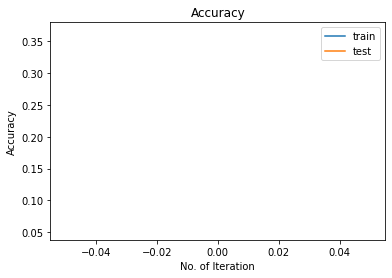

In [ ]:
#Ploting the Accuracy

plt.plot(model_fitMobileNetV2.history['accuracy'])
plt.plot(model_fitMobileNetV2.history['val_accuracy'])
plt.ylabel("Accuracy");plt.xlabel("No. of Iteration"); plt.title("Accuracy")
plt.legend(['train', 'test'])

Unfreeze the entire model and lower learning rate for a fine-tuning run. Learning rate is lowered significantly for the fine-tuning run

In [ ]:
for layer in modelMobileNetV2.layers:
    layer.trainable = True


modelMobileNetV2.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.0001), metrics=['accuracy'])

Do one pass through as a fine tuning run.

In [ ]:
model_fitMobileNetV2 = modelMobileNetV2.fit_generator(generator = train_generator,
                    steps_per_epoch = 74,
                    validation_data = validation_generator, 
                    validation_steps = 18,
                    epochs = 1)

Epoch 1/1
73/73 [==============================] - 115s 2s/step - loss: 0.9367 - accuracy: 0.7992 - val_loss: 2.7740 - val_accuracy: 0.4224


Create a confusion matrix to visualize all 102 classes

In [ ]:
#Plotting the confusion Matrix 
test_predictions = modelMobileNetV2.predict_generator(generator = validation_generator,
                    steps = 18)


In [ ]:
fig = plt.figure(figsize=(20,20)) 

test_predictions2 = np.argmax(test_predictions,axis=-1)
matrix = confusion_matrix(validation_generator.classes,test_predictions2)
sns.heatmap(matrix.T, square=True, annot=True, cbar=False,cmap=plt.cm.Greys)
plt.xlabel('Predicted Labels'); plt.ylabel('True Labels'); plt.show();

ValueError: ignored

<Figure size 1440x1440 with 0 Axes>

In [ ]:
print(test_predictions2.shape)

(900,)


# Step 2 and 3 revisited

We chose VGG16 as our second neural net to play with. Because it's a bigger 


In [ ]:
from keras.applications.vgg16 import VGG16



modelVGG16 = VGG16(input_shape = (224,224,3), weights = 'imagenet', include_top=False)

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
modelVGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
batch_size = 50;

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)


train_generator = train_datagen.flow_from_directory(
        "./101_ObjectCategories",  
        target_size=(224,224),  
        batch_size=batch_size,
        subset='training')  

validation_generator = train_datagen.flow_from_directory(
        "./101_ObjectCategories",  
        target_size=(224,224),  
        batch_size=batch_size,
        subset='validation')  

Found 7356 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.


Run VGG16 for feature extraction once - use this in the relatively simple NN we build later on

In [ ]:
modelVGG16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




Modify output only so that data is in a more manageable format


In [ ]:
for layer in modelVGG16.layers:
    layer.trainable=False

x=modelVGG16.output
x=GlobalAveragePooling2D()(x)



modelVGG16=Model(inputs=modelVGG16.input,outputs=x)



modelVGG16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])









Generate features from VGG16

In [ ]:

vgg16_features = modelVGG16.predict_generator(generator = train_generator,
                    steps = 148)




In [ ]:

vgg16_featuresTest = modelVGG16.predict_generator(generator = validation_generator,
                    steps = 36)
vgg16_featuresTest = np.expand_dims(vgg16_featuresTest,2)

In [ ]:
vgg16_features = np.expand_dims(vgg16_features,2)
print(vgg16_features.shape)

(7356, 512, 1)


One-hot encode labels to make Keras happy

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
labels4vgg = lb.fit_transform(train_generator.classes)
labels4vggTest = lb.fit_transform(validation_generator.classes)
print(labels4vgg.shape)


[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


Run said features through a simple NN - borrowing the model from the one we developed for the last assignment

In [ ]:
# Building, Compiling and Fitting a Keras Model. 

#def keras_model():
model = Sequential() #Sequential creates a linear stack of the neural network layers.
#Adding Layers
  

#Adding the first dense Layer
model.add(Dense(512, input_shape =(512,1)))#
model.add(Activation('relu'))
model.add(Dropout(0.1))

#Adding the second layer
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Flatten())
  
#Adding the seconds layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))


#Adding the seconds layer
model.add(Dense(256))
model.add(Activation('relu'))


#Add an output layer
model.add(Dense(102,activation='softmax'))

# visualize the model
print(model.summary())
 
  


# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 512, 512)          1024      
_________________________________________________________________
activation_24 (Activation)   (None, 512, 512)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 512)          0         
_________________________________________________________________
dense_41 (Dense)             (None, 512, 256)          131328    
_________________________________________________________________
activation_25 (Activation)   (None, 512, 256)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)             

In [ ]:
model_fit = model.fit(vgg16_features,labels4vgg, epochs = 200,shuffle='batch')

Epoch 1/20
7356/7356 [==============================] - 4s 532us/step - loss: 4.4614 - accuracy: 0.0776
Epoch 2/20
7356/7356 [==============================] - 4s 528us/step - loss: 4.3376 - accuracy: 0.0763
Epoch 3/20
7356/7356 [==============================] - 4s 526us/step - loss: 4.2943 - accuracy: 0.0774
Epoch 4/20
7356/7356 [==============================] - 4s 530us/step - loss: 4.2442 - accuracy: 0.0759
Epoch 5/20
7356/7356 [==============================] - 4s 529us/step - loss: 4.2277 - accuracy: 0.0825
Epoch 6/20
7356/7356 [==============================] - 4s 533us/step - loss: 4.2185 - accuracy: 0.0689
Epoch 7/20
7356/7356 [==============================] - 4s 532us/step - loss: 4.2159 - accuracy: 0.0621
Epoch 8/20
7356/7356 [==============================] - 4s 530us/step - loss: 4.2092 - accuracy: 0.0716
Epoch 9/20
7356/7356 [==============================] - 4s 527us/step - loss: 4.2057 - accuracy: 0.0579
Epoch 10/20
7356/7356 [==============================] - 4s 530u

1788/1788 [==============================] - 0s 119us/step
Accuracy for the test Model is 8.892617374658585 %
Loss for the test Model is 4.167471864346156


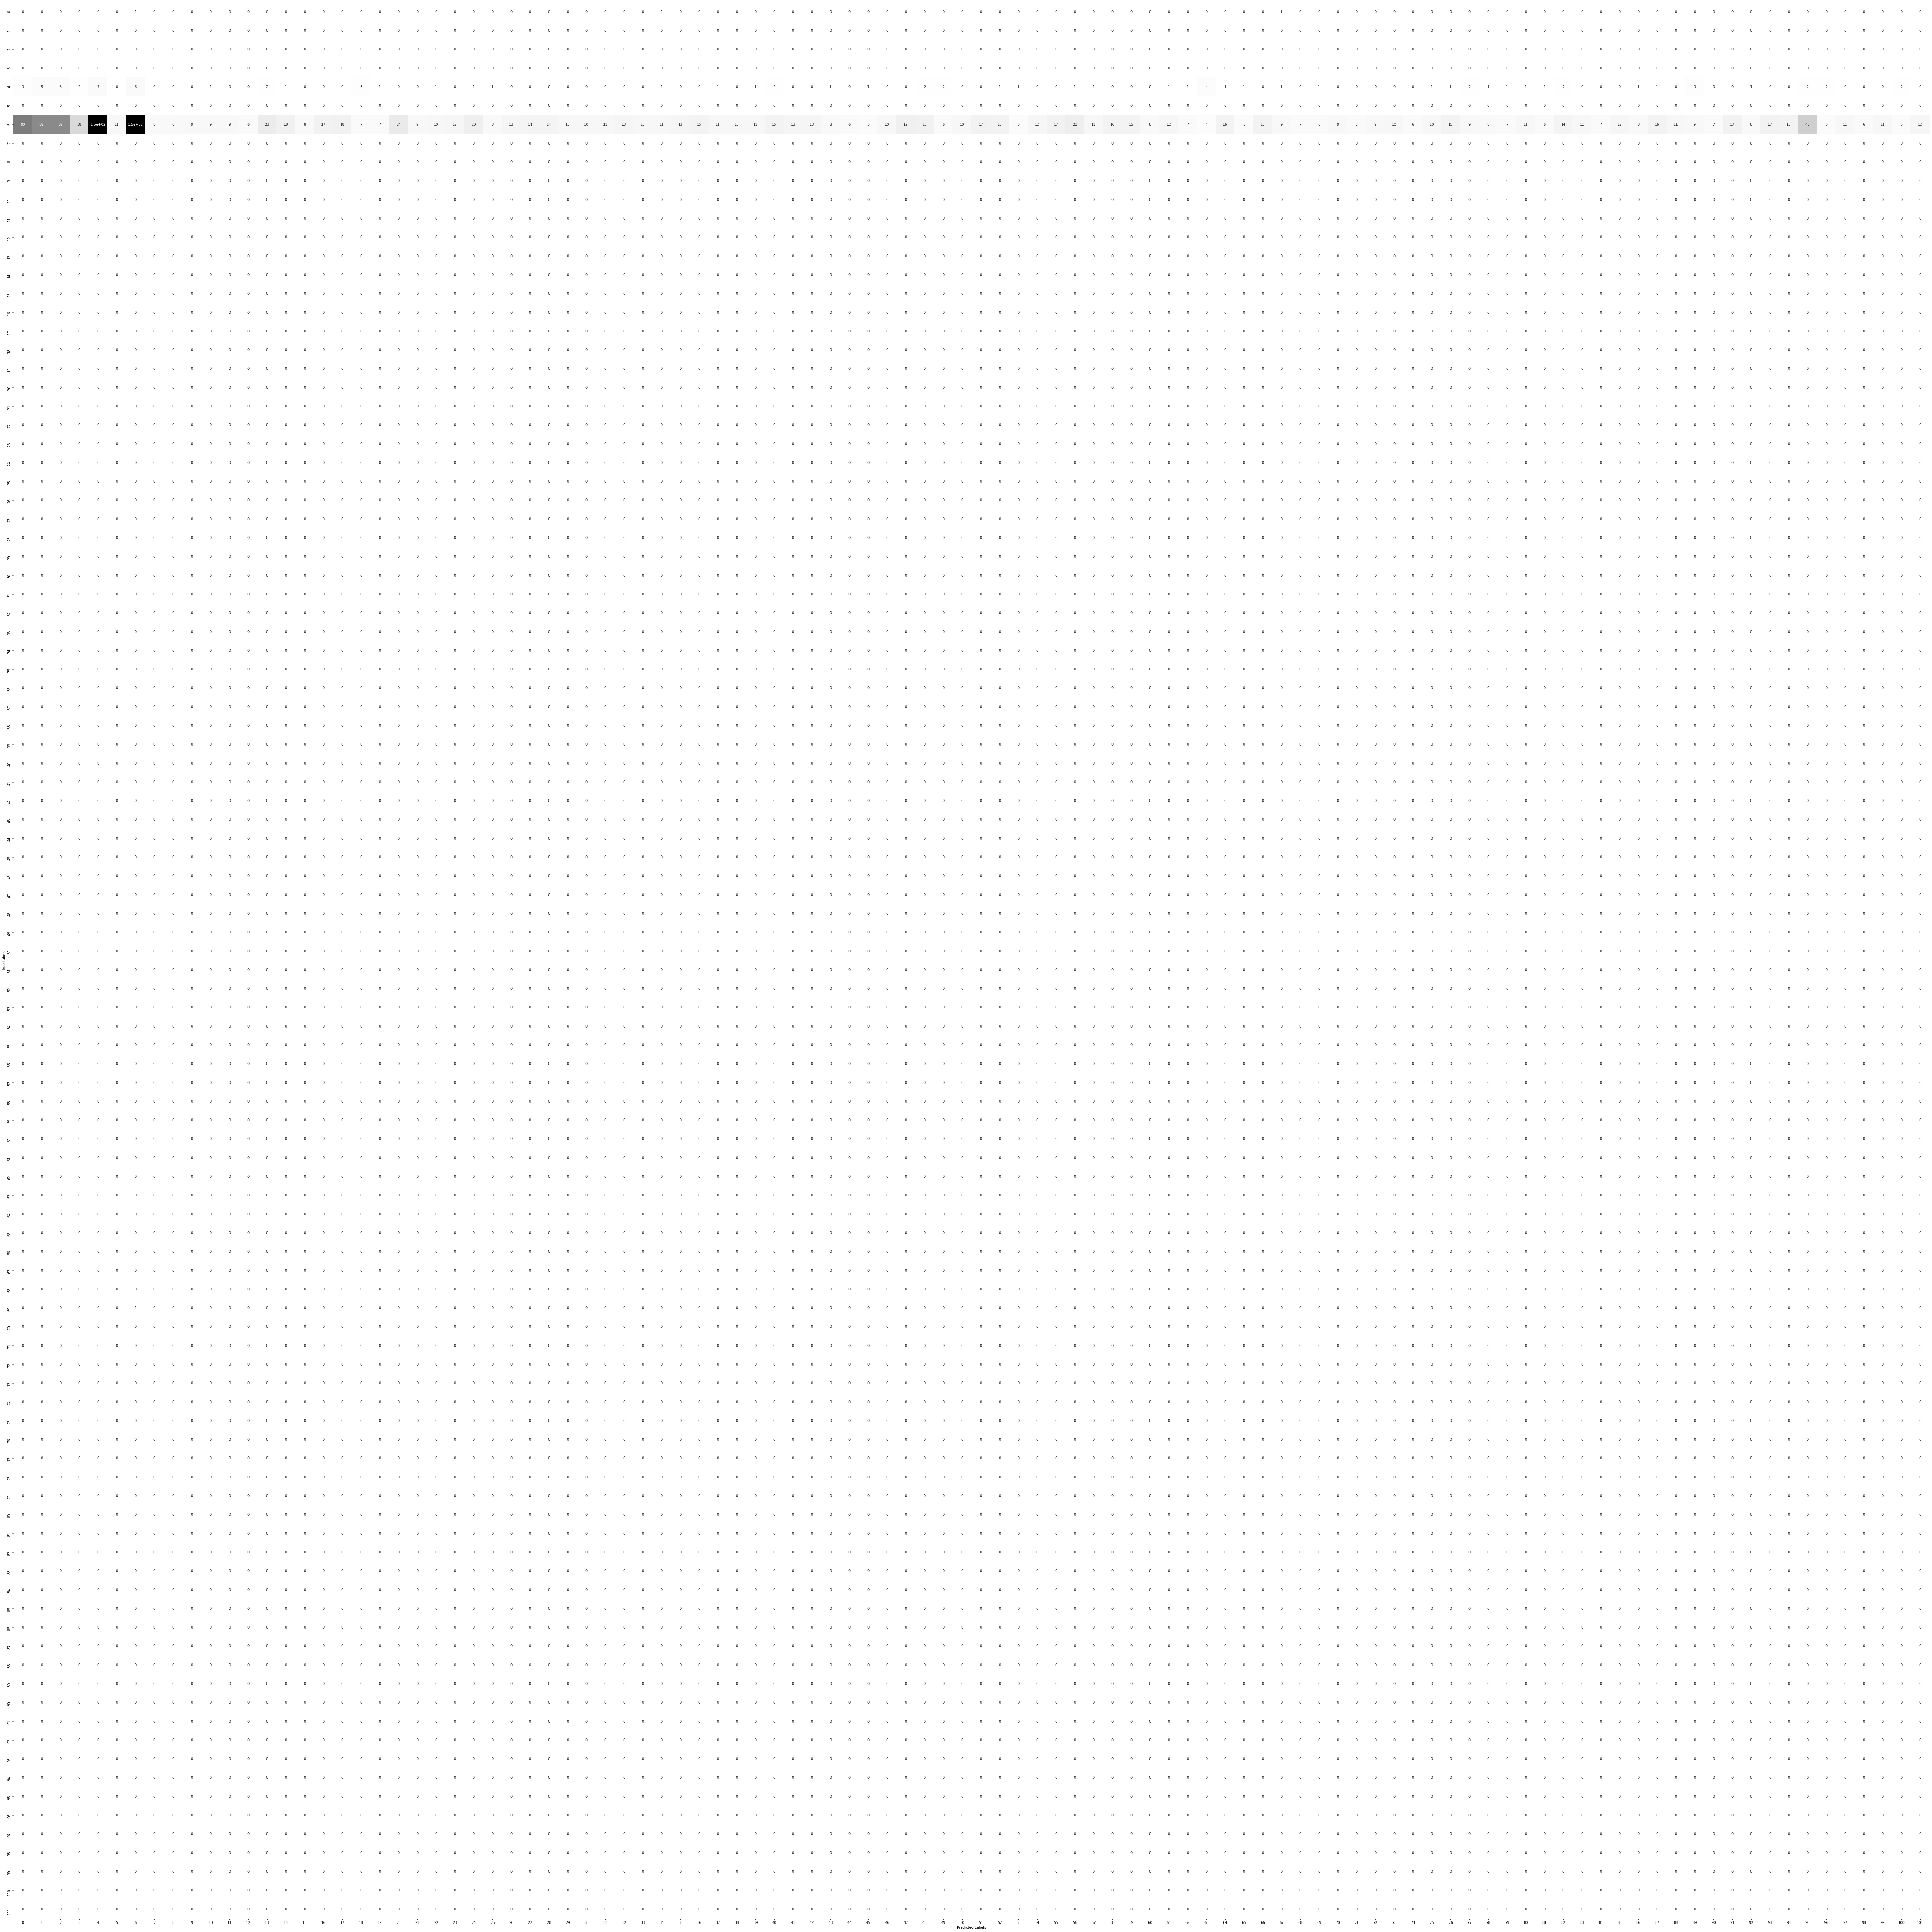

In [ ]:
score = model.evaluate(vgg16_featuresTest,labels4vggTest)



print("Accuracy for the test Model is {} %".format(score[1]*100))
print("Loss for the test Model is {}".format(score[0]))



#Plotting the confusion Matrix 

fig = plt.figure(figsize=(10,10)) 

test_predictions = np.argmax(model.predict(vgg16_featuresTest),axis=-1)
matrix = confusion_matrix(validation_generator.classes,test_predictions)
sns.heatmap(matrix.T, square=True, annot=True, cbar=False,cmap=plt.cm.Greys)
plt.xlabel('Predicted Labels'); plt.ylabel('True Labels'); plt.show();

We chose not to run a fine-tuning of the VGG16, but if we did we would use the following code:

In [ ]:

model_fitVGG16 = modelVGG16.fit_generator(generator = train_generator,
                    steps_per_epoch = 140,
                    validation_data = validation_generator, 
                    validation_steps = 20,
                    epochs = 20)

# Discussion of results
